In [1]:
import pandas as pd

In [2]:
import itertools

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np

In [7]:
import matplotlib.pyplot as plt

In [8]:
import xgboost as xgb

In [11]:
from lightgbm import LGBMClassifier

In [12]:
import os

In [13]:
import seaborn as sns

In [17]:
from wordcloud import WordCloud

In [19]:
df = pd.read_csv('malicious_phish.csv')
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [21]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [22]:
#plotting the word cloud to know keywords in the URL
#for that we are first seperating all the types of URLs
df_phish = df[df.type == 'phishing']
df_malware = df[df.type == 'malware']
df_deface = df[df.type == 'defacement']
df_benign = df[df.type == 'benign']

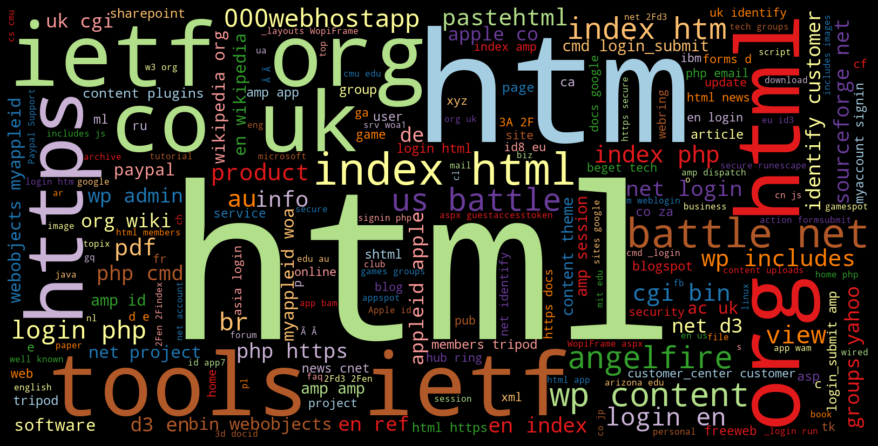

In [23]:
#wordcloud
#the words with high frequecy will be of high size
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width = 1600, height = 800, colormap = 'Paired').generate(phish_url)
plt.figure(figsize=(12,14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

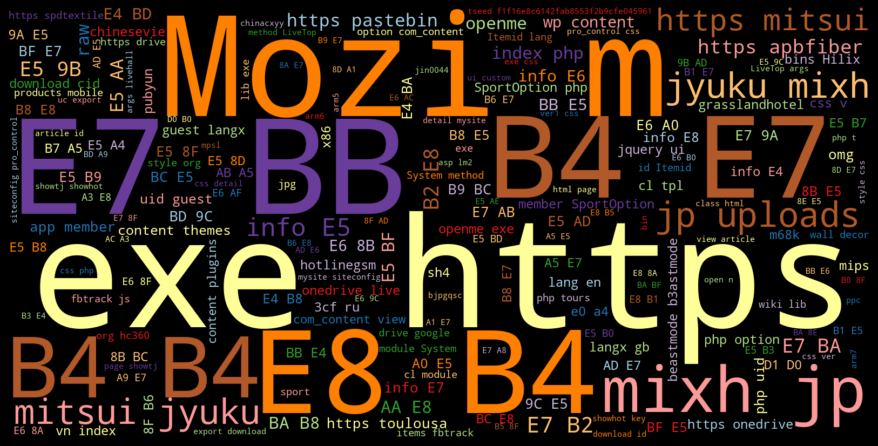

In [25]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width = 1600, height = 800, colormap = 'Paired').generate(malware_url)
plt.figure(figsize=(12,14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

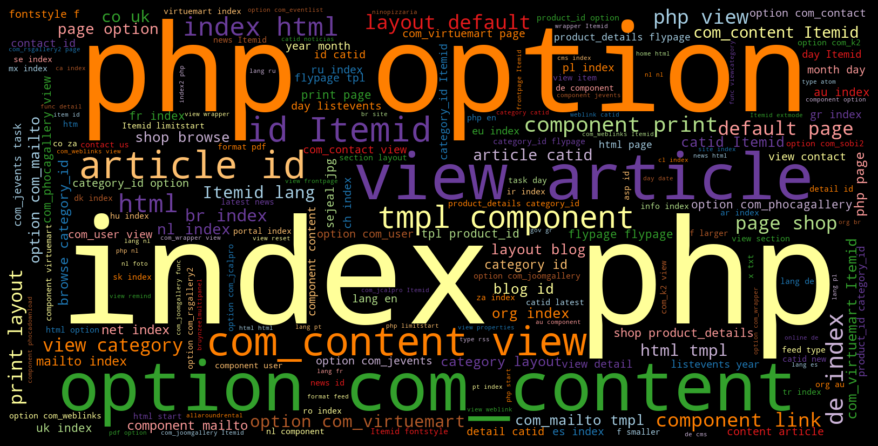

In [26]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width = 1600, height = 800, colormap = 'Paired').generate(deface_url)
plt.figure(figsize=(12,14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

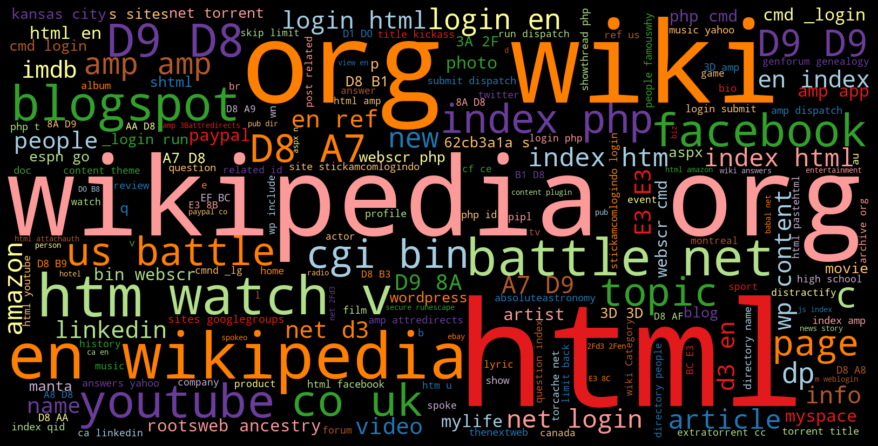

In [27]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width = 1600, height = 800, colormap = 'Paired').generate(benign_url)
plt.figure(figsize=(12,14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [37]:
#now creating lexical features for the ml model
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)
    if match:
        return 1
    else:
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [40]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [41]:
!pip install googlesearch-python

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for googlesearch-python: filename=googlesearch_python-1.2.3-py3-none-any.whl size=4231 sha256=ae9d8e3bcdb7179246e528490dec73c8ce8d1943fedfd08b74cbe24e8b4ba538
  Stored in directory: c:\users\gaganchandra\appdata\local\pip\cache\wheels\be\78\a3\d80e85ac9551489cd9c44f59a0bc5972e79e680ce9cc6055ca
Successfully built googlesearch-python

[notice] A new release of pip available: 22.1.2 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
from googlesearch import search

In [44]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [45]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot
df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [46]:
def count_www(url):
    url.count('www')
    return url.count('www')
df['count-www'] = df['url'].apply(lambda i: count_www(i))


def count_atrate(url):
    return url.count('@')
df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))


def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [50]:
def count_https(url):
    return url.count('https')
df['count-https'] = df['url'].apply(lambda i: count_https(i))


def count_http(url):
    return url.count('http')
df['count-http'] = df['url'].apply(lambda i: count_http(i))


def count_per(url):
    return url.count('%')
df['count%'] = df['url'].apply(lambda i: count_per(i))


def count_ques(url):
    return url.count('?')
df['count?'] = df['url'].apply(lambda i: count_ques(i))


def count_hyphen(url):
    return url.count('-')
df['count-'] = df['url'].apply(lambda i: count_hyphen(i))


def count_equal(url):
    return url.count('=')
df['count='] = df['url'].apply(lambda i: count_equal(i))


def url_length(url):
    return len(str(url))
df['url-length'] = df['url'].apply(lambda i: url_length(i))


def hostname_length(url):
    return len(urlparse(url).netloc)
df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))


def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr', url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits += 1
    return digits
df['count-digits'] = df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters
df['count-letters'] = df['url'].apply(lambda i: letter_count(i))


df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,...,count-http,count%,count?,count-,count=,url-length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [51]:
!pip install tld

     ------------------------------------ 263.8/263.8 kB 953.2 kB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
from urllib.parse import urlparse
from tld import get_tld
import os.path


def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0
df['fd_length'] = df['url'].apply(lambda i: fd_length(i))


df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently = True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

    
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [54]:
df = df.drop('tld',1)

C:\Users\GAGANCHANDRA\AppData\Local\Temp\ipykernel_9284\296055309.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('tld',1)


In [55]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domain', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url-length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [56]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [57]:
#EDA

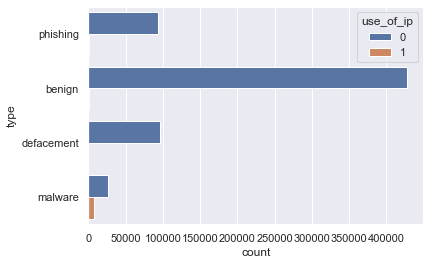

In [58]:
#ip address
sns.set(style = "darkgrid")
ax = sns.countplot(y = "type", data = df, hue = "use_of_ip")

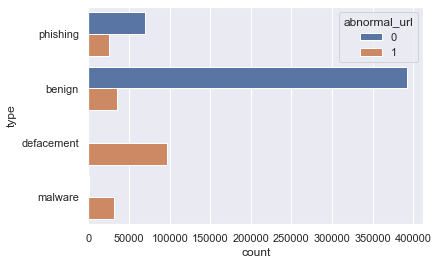

In [59]:
#abnormal url
sns.set(style = "darkgrid")
ax = sns.countplot(y = "type", data=df, hue = "abnormal_url")

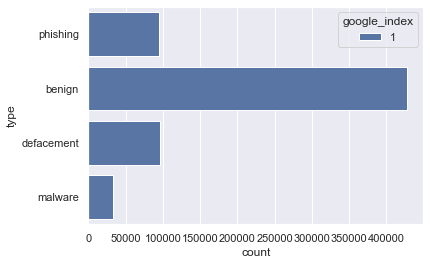

In [60]:
#google index
sns.set(style = "darkgrid")
ax = sns.countplot(y = "type", data=df, hue = "google_index")

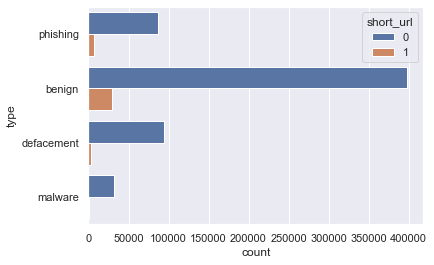

In [61]:
#shorturl
sns.set(style="darkgrid")
ax = sns.countplot(y="type",data=df, hue="short_url")

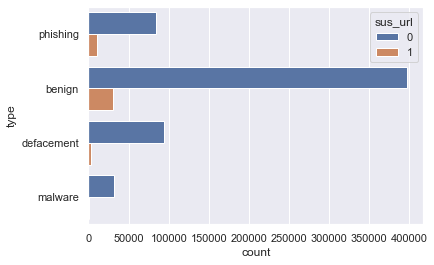

In [62]:
#suspicious url
sns.set(style="darkgrid")
ax = sns.countplot(y="type",data=df, hue="sus_url")

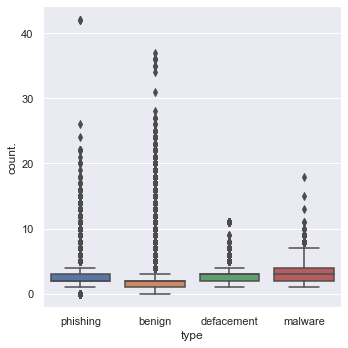

In [66]:
#count dot url
sns.set(style="darkgrid")
ax = sns.catplot(x="type",y="count.", kind="box", data=df)

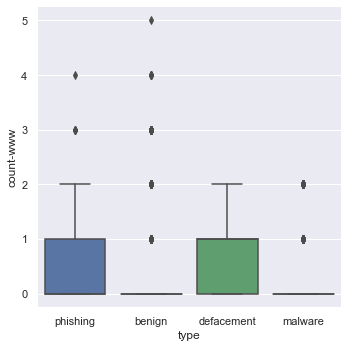

In [67]:
#count www
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

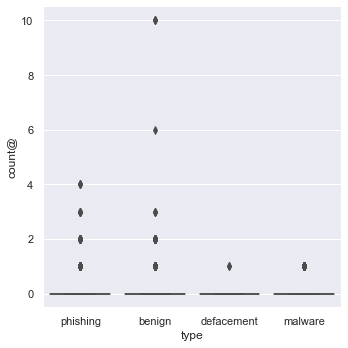

In [68]:
#count @
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count@", kind="box", data=df)

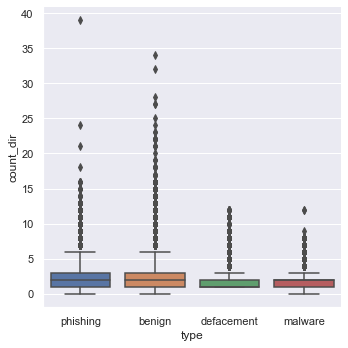

In [69]:
#count dir
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

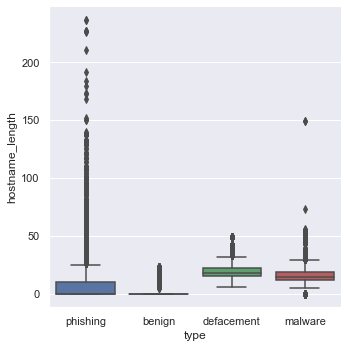

In [70]:
#hostname length
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

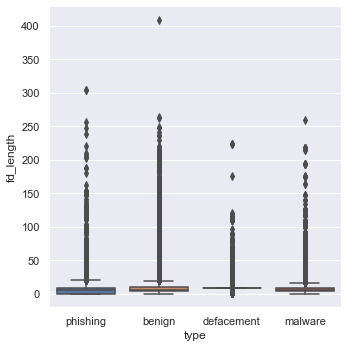

In [71]:
#first directory length
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

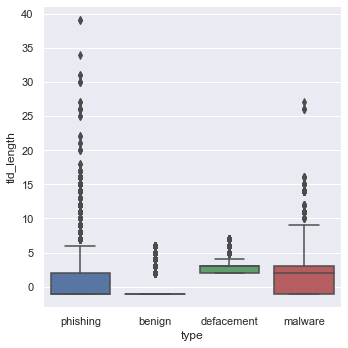

In [72]:
#tld length
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

In [77]:
#target encoding
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df['type_code'] = lb_make.fit_transform(df['type'])
df['type_code'].value_counts()
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domain,...,count-,count=,url-length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld_length,type_code
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,1,0,16,0,0,0,13,0,-1,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,35,0,0,1,29,5,-1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,31,0,0,1,25,7,-1,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,4,88,21,0,7,63,9,2,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,3,235,23,0,22,199,9,3,1


In [78]:
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domain', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url-length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

y = df['type_code']

In [79]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domain,short_url,count-https,count-http,...,count?,count-,count=,url-length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [80]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)

In [81]:
#model building

In [85]:
#random forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=['benign', 'defacement', 'phishing', 'malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print('accuracy: %0.3f'%score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.94      0.96      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy: 0.966
